<a href="https://colab.research.google.com/github/lonespear/MA206/blob/main/QuantitativeFinance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantitative Finance: Time Series Modeling & Risk Analysis  
### *by CPT Jonathan Day*

This course module introduces cadets to core techniques in quantitative finance, with a focus on time series modeling and risk quantification. Through hands-on analysis in Python, students explore:

- **Autoregressive (AR), ARIMA, ARCH, and GARCH models** for forecasting and volatility modeling  
- **Copulas** for multivariate dependence structures and risk aggregation  
- **Empirical asset returns** using real financial data from `yfinance`  
- **Visualization tools** for diagnosing residuals, volatility clustering, and dependence  
- **Applications** to portfolio risk, value-at-risk, and financial decision-making

This notebook is structured to build both conceptual understanding and practical skills needed to evaluate, interpret, and model financial data under uncertainty.


In [3]:
# Run these to install necessary dependencies
!pip install copulas
!pip install yfinance
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.8 MB/s eta 0:00:00


In [94]:
# Load necessary dependencies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize
from scipy.stats import norm, t, gaussian_kde
from scipy import stats
from sklearn.preprocessing import QuantileTransformer
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from copulas.multivariate import GaussianMultivariate
from ipywidgets import interact, Dropdown, FloatSlider, IntSlider

## 📈 Modeling Asset Returns

Before diving into portfolio optimization, we must first understand how **individual asset returns behave**.

We often model **log-returns** of an asset — the natural logarithm of relative price change — because:

- Log-returns are **time-additive**, simplifying analysis over different periods.
- They tend to have better statistical properties (e.g., more symmetric distributions).
- They are consistent with **geometric compounding**.

For asset price $P_t$, the log-return is:

$$
r_t = \log\left(\frac{P_t}{P_{t-1}}\right)
$$

---

### 🔍 Fitting a $t$-distribution to Asset Returns

Empirical asset returns frequently exhibit **fat tails** — large shocks occur more often than expected under a normal distribution.

To account for this, we can fit a **Student's $t$-distribution**, which has heavier tails and one additional parameter: the **degrees of freedom ($\nu$)**.

The PDF of the $t$-distribution is:

$$
f(r) = \frac{\Gamma\left(\frac{\nu + 1}{2}\right)}{\sqrt{\nu \pi} \, \Gamma\left(\frac{\nu}{2}\right)} \left[1 + \frac{(r - \mu)^2}{\nu \sigma^2} \right]^{-\frac{\nu + 1}{2}}
$$

Let’s see this in action:


[*********************100%***********************]  1 of 1 completed


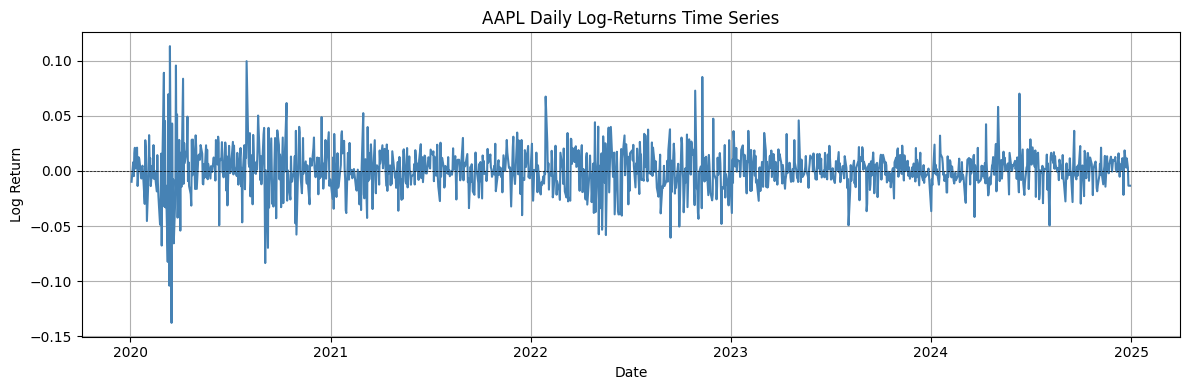

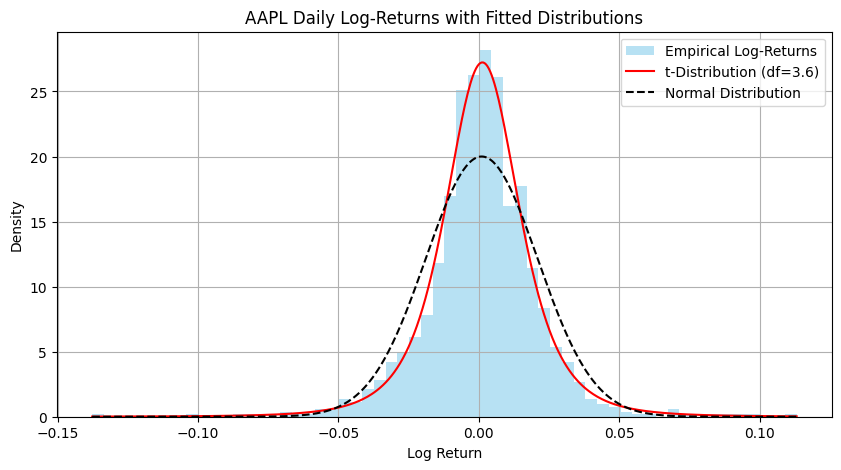

In [72]:
# Load historical daily price data
ticker = 'AAPL'
df = yf.download(ticker, start='2020-01-01', end='2024-12-31', auto_adjust=True)
prices = df['Close']
log_returns = np.log(prices / prices.shift(1)).dropna()

# Fit a t-distribution to log returns
params = t.fit(log_returns)  # returns df, loc, scale
df_t, mu_t, sigma_t = params

# Compare histogram to fitted t-distribution
x = np.linspace(log_returns.min(), log_returns.max(), 500)
pdf_t = t.pdf(x, df_t, loc=mu_t, scale=sigma_t)
pdf_n = norm.pdf(x, loc=log_returns.mean(), scale=log_returns.std())

# Plot time series of log-returns
plt.figure(figsize=(12, 4))
plt.plot(log_returns.index, log_returns, color='steelblue')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.title(f"{ticker} Daily Log-Returns Time Series")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(log_returns, bins=60, density=True, alpha=0.6, color='skyblue', label='Empirical Log-Returns')
plt.plot(x, pdf_t, 'r-', label=f"t-Distribution (df={df_t:.1f})")
plt.plot(x, pdf_n, 'k--', label="Normal Distribution")
plt.title(f"{ticker} Daily Log-Returns with Fitted Distributions")
plt.xlabel("Log Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

> ⚠️ **IMPORTANT INFO**
>
> If there's one thing you should take away from this notebook, it's this:
>
> **Stock returns are *not* normally distributed.**
>
> Real-world returns often exhibit **fat tails**, **skewness**, and **volatility clustering** — all of which violate the assumptions of normality.  
>  
> That’s why we fit a **t-distribution** here: it allows for heavier tails, better reflecting the risks involved in financial markets.
>
>[If you still don't believe me, learn why 2008 happened.](https://www.wired.com/2009/02/wp-quant/)

# 📊 Modern Portfolio Theory (MPT)

Modern Portfolio Theory (MPT), introduced by Harry Markowitz in the early 1950s and popularized in the 1980s with broader computational access, provides a rigorous mathematical framework for constructing investment portfolios that **maximize expected return for a given level of risk**.

MPT formalized the idea that a diversified portfolio can be **more efficient** than any single investment. It laid the groundwork for risk-return optimization and introduced key concepts like the **Efficient Frontier**, **Capital Market Line (CML)**, and **Sharpe Ratio**.

> 🎥 *Recommended video:*  
> ["Modern Portfolio Theory Explained"](https://www.youtube.com/watch?v=rn8aL9iFMRs) *(Ben Felix, 10 mins)*

---

💼 Why Optimize a Portfolio?

Imagine you're building a long-term investment portfolio — maybe a mix of stocks, bonds, gold, and real estate. Should you:

- Just pick the top performers from last year?
- Distribute funds equally across assets?
- Favor assets with the highest return?

🧠 Intuition tells us that some assets are riskier than others, and that combining them can reduce overall volatility. But how exactly do we trade off risk and return in a mathematically optimal way?

That's where **Modern Portfolio Theory (MPT)** comes in.

🧾 MPT shows that *diversification — thoughtfully combining assets with different risk-return profiles* — can produce portfolios that offer higher returns for the same risk or lower risk for the same return.

MPT transforms portfolio construction from an art into a science.

---

## 🔢 Mathematical Foundation

Let:

- $\mu_i$: expected return of asset $i$  
- $\sigma_i$: standard deviation (risk) of asset $i$  
- $w_i$: weight of asset $i$ in the portfolio  
- $\vec{w}$: vector of portfolio weights  
- $\vec{\mu}$: vector of expected asset returns  
- $\Sigma$: covariance matrix of asset returns  
- $r_f$: risk-free rate

Then:

- **Portfolio Return**:  
  $\mu_p = \vec{w}^\top \vec{\mu}$

- **Portfolio Variance**:  
  $\sigma_p^2 = \vec{w}^\top \Sigma \vec{w}$

- **Portfolio Standard Deviation**:  
  $\sigma_p = \sqrt{\vec{w}^\top \Sigma \vec{w}}$

- **Sharpe Ratio (risk-adjusted return)**:  
  $SR = \frac{\mu_p - r_f}{\sigma_p}$

---

### 💰 Capital Market Line (CML)

Linear relationship between risk and return when a risk-free asset is available:

$\mu_p = r_f + \frac{\mu_m - r_f}{\sigma_m} \cdot \sigma_p$

where:  
- $\mu_p$: expected return of the portfolio  
- $r_f$: risk-free rate  
- $\mu_m$, $\sigma_m$: return and standard deviation of the market (tangency) portfolio  
- $\sigma_p$: portfolio standard deviation

---

## 🎯 Optimization Objectives

Different portfolio strategies solve different optimization problems:

- **Minimum Variance Portfolio**  
  Minimize $\sigma_p^2$ subject to $\sum w_i = 1$

- **Tangency Portfolio (Max Sharpe)**  
  Maximize $SR = \frac{\mu_p - r_f}{\sigma_p}$

- **Target Return Portfolio**  
  Minimize $\sigma_p^2$ subject to $\mu_p = R_{\text{target}}$

Each solution maps to a point on the **Efficient Frontier**.

---

## 📈 Extensions and Applications

- **Covariance Estimation**: Led to shrinkage estimators, bootstrapping, and Bayesian approaches  
- **Factor Models**: e.g., CAPM, Fama-French 3-factor and 5-factor models  
- **Risk Models**: GARCH, copulas, and Monte Carlo simulation

MPT remains foundational in finance — powering everything from asset allocation models to automated robo-advisory strategies.

---

Now we’ll bring Modern Portfolio Theory to life by downloading historical data for a diverse set of assets, computing log returns, and estimating the expected return vector $\vec{\mu}$ and covariance matrix $\Sigma$ to power portfolio optimization.

In [24]:
# ---- choose tickers (feel free to swap/extend) ----
tickers = [
    # --- Core ETFs ---
    "SPY", "QQQ", "IAU", "GOVT", "VNQ", "VTI", "EFA", "IWM", "XLK", "XLF",

    # --- Tech ---
    "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "TSLA", "META", "ORCL", "INTC", "AMD",

    # --- Consumer / Retail ---
    "CMG", "MCD", "SBUX", "TGT", "WMT", "COST", "NKE", "MNST", "KO", "TXRH",

    # --- Industrials / Transportation ---
    "ALK", "DAL", "UPS", "UNP", "CAT", "LOVE",

    # --- Healthcare / Pharma ---
    "JNJ", "PFE", "MRK", "UNH", "ABT",

    # --- Financials ---
    "JPM", "GS", "BAC", "WFC", "AXP",

    # --- Energy / Utilities ---
    "XOM", "CVX", "SLB", "NEE", "DUK",

    # --- REITs / Real Assets ---
    "LOPE", "O", "PLD", "AMT", "CCI"
]

# pull adj close (10y daily by default; you can set period="max" or a start=)
px = yf.download(tickers, period="10y", auto_adjust=True, progress=False)["Close"]

# compute daily log returns, then annualize (μ ≈ mean*252, Σ ≈ cov*252)
rets = np.log(px/px.shift(1)).dropna()
mu = rets.mean().values * 252
Sigma = rets.cov().values * 252

assets = np.array(tickers)
n = len(assets)

In [56]:
def portfolio_stats(w, mu, Sigma):
    """Return (annualized_return, annualized_vol, sharpe) for weights w."""
    r = float(w @ mu)
    v = float(np.sqrt(w @ Sigma @ w))
    return r, v, r / v

def weight_constraints(n, allow_short=False):
    """Sum-to-1 constraint and bounds (with or without short selling)."""
    cons = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1.0},)
    if allow_short:
        # Allow shorting: e.g., -1 ≤ wᵢ ≤ 1 for each asset
        bounds = tuple((-1.0, 1.0) for _ in range(n))
    else:
        # No shorting: 0 ≤ wᵢ ≤ 1
        bounds = tuple((0.0, 1.0) for _ in range(n))
    return cons, bounds

def min_var_for_target_return(target_r, mu, Sigma, allow_short=False):
    """Minimum-variance portfolio achieving target return."""
    cons, bounds = weight_constraints(len(mu), allow_short)
    cons = cons + ({'type':'eq', 'fun': lambda w, mu=mu, tr=target_r: w @ mu - tr},)
    w0 = np.ones(len(mu)) / len(mu)
    res = minimize(lambda w, S=Sigma: w @ S @ w, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

def global_min_var(mu, Sigma, allow_short=False):
    """Global minimum-variance portfolio (GMV)."""
    cons, bounds = weight_constraints(len(mu), allow_short)
    w0 = np.ones(len(mu)) / len(mu)
    res = minimize(lambda w, S=Sigma: w @ S @ w, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

def tangency_portfolio(mu, Sigma, rf=0.02, allow_short=False):
    """Max Sharpe (tangency) portfolio with risk-free rate rf."""
    # maximize (w·(mu - rf))/sqrt(w Σ w)  ≡ maximize Sharpe
    # equivalent: minimize negative Sharpe; we’ll use a scale-free form
    excess = mu - rf
    def neg_sharpe(w):
        r, v, _ = portfolio_stats(w, mu, Sigma)
        return -(r - rf) / v
    cons, bounds = weight_constraints(len(mu), allow_short)
    w0 = np.ones(len(mu)) / len(mu)
    res = minimize(neg_sharpe, w0, method='SLSQP', bounds=bounds, constraints=cons)
    return res.x

In [57]:
# pick a reasonable span of target returns
w_gmv = global_min_var(mu, Sigma, allow_short=False)
r_gmv, v_gmv, _ = portfolio_stats(w_gmv, mu, Sigma)

r_min, r_max = r_gmv, max(mu)  # conservative span
targets = np.linspace(r_min, r_max, 60)

frontier = []
weights_on_frontier = []
for tr in targets:
    try:
        w = min_var_for_target_return(tr, mu, Sigma, allow_short=False)
        r, v, s = portfolio_stats(w, mu, Sigma)
        frontier.append((r, v))
        weights_on_frontier.append(w)
    except Exception:
        pass  # infeasible target (e.g., no-shorting can create gaps)

frontier = np.array(frontier)


In [58]:
rf = 0.043  # set annual risk-free rate based on 10-yr treasury bond
w_tan = tangency_portfolio(mu, Sigma, rf=rf, allow_short=False)
r_tan, v_tan, s_tan = portfolio_stats(w_tan, mu, Sigma)

# Capital Market Line: from rf through tangency
v_line = np.linspace(0, frontier[:,1].max(), 50)
r_line = rf + s_tan * v_line


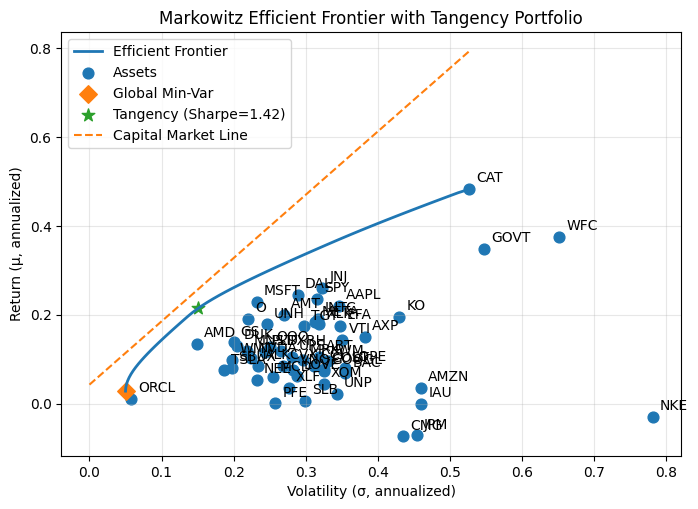

Tangency weights:


,Weight
AAPL,0.005
MSFT,0.162
AMD,0.462
TGT,0.013
CAT,0.122
JNJ,0.075
WFC,0.013
O,0.148



GMV weights:


,Weight
XLK,0.012
ORCL,0.858
SBUX,0.021
TGT,0.031
ALK,0.012
XOM,0.007
SLB,0.002
LOPE,0.008
O,0.027
CCI,0.021



Top Longs:
 JNJ    0.075
CAT    0.122
O      0.148
MSFT   0.162
AMD    0.462
dtype: float64


In [59]:
fig, ax = plt.subplots(figsize=(8.0, 5.5))

# efficient frontier
ax.plot(frontier[:,1], frontier[:,0], lw=2, label="Efficient Frontier")

# scatter individual assets
asset_vols = np.sqrt(np.diag(Sigma))
ax.scatter(asset_vols, mu, s=60, marker='o', label="Assets")
for i, t in enumerate(assets):
    ax.annotate(t, (asset_vols[i], mu[i]), xytext=(5,5), textcoords='offset points')

# GMV and Tangency
ax.scatter(v_gmv, r_gmv, s=80, marker='D', label="Global Min-Var")
ax.scatter(v_tan, r_tan, s=90, marker='*', label=f"Tangency (Sharpe={s_tan:.2f})")

# CML
ax.plot(v_line, r_line, ls='--', label="Capital Market Line")

ax.set_xlabel("Volatility (σ, annualized)")
ax.set_ylabel("Return (μ, annualized)")
ax.set_title("Markowitz Efficient Frontier with Tangency Portfolio")
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

tan_wt = pd.Series(w_tan, index=assets, name="Weight")
gmv_wt = pd.Series(w_gmv, index=assets, name="Weight")

# show weights nicely
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
print("Tangency weights:")
display(tan_wt[np.abs(tan_wt) > 1e-3])
print("\nGMV weights:")
display(gmv_wt[np.abs(gmv_wt) > 1e-3])

# Checks if allowed shorting
sorted_weights = pd.Series(w_tan, index=assets).sort_values()
#print("Top Shorts:\n", sorted_weights.head(5))
print("\nTop Longs:\n", sorted_weights.tail(5))
# print("Sum of weights (should be 1):", np.sum(w_tan))


---

### 🧾 Tangency Portfolio Results Summary

The **Tangency Portfolio**, shown as a green star on the Efficient Frontier plot, is the unique portfolio that:

- Maximizes the **Sharpe Ratio**:
  $$
  SR = \frac{\mu_p - r_f}{\sigma_p}
  $$

- Lies at the tangency point between the **Efficient Frontier** and the **Capital Market Line (CML)**:
  $$
  \mu_p = r_f + \frac{\mu_m - r_f}{\sigma_m} \cdot \sigma_p
  $$

Key characteristics:

- **Top-weighted assets**:  
  - e.g., `AMD`, `MSFT`, `BRK.B` (check output above)

- **Expected Annual Return**:
  $$
  \mu_{\text{tan}} = \vec{w}_{\text{tan}}^\top \vec{\mu}
  $$

- **Portfolio Volatility**:
  $$
  \sigma_{\text{tan}} = \sqrt{\vec{w}_{\text{tan}}^\top \Sigma \vec{w}_{\text{tan}}}
  $$

- **Sharpe Ratio**:
  $$
  SR = \frac{\mu_{\text{tan}} - r_f}{\sigma_{\text{tan}}}
  $$

Use the code cell below to compute these values in Python:

In [60]:
mu_tan = w_tan @ mu
sigma_tan = np.sqrt(w_tan @ Sigma @ w_tan)
sr_tan = (mu_tan - rf) / sigma_tan

print(f"Expected Annual Return (μ): {mu_tan:.3f}")
print(f"Volatility (σ): {sigma_tan:.3f}")
print(f"Sharpe Ratio: {sr_tan:.2f}")

Expected Annual Return (μ): 0.215
Volatility (σ): 0.151
Sharpe Ratio: 1.14


Now that we see what modeling a portfolio is like just using long positions, enable short trades by changing the `allow_short` to `True` and note the change in the Sharpe Ratio. Do you think implementing this strategy is realistic? What may be some overlooked aspects of this model?

---

## 📉 Understanding Volatility and Risk Measures

Once we've defined the **expected return** of a portfolio, the natural next question is:  
> _How risky is this return?_  

This is where **volatility** comes in.

### 🔁 Volatility as a Measure of Risk

Volatility is typically measured as the **standard deviation** of portfolio returns:
$$
\sigma_p = \sqrt{\mathbf{w}^T \Sigma \mathbf{w}}
$$
where:
- $\mathbf{w}$ is the vector of portfolio weights  
- $\Sigma$ is the covariance matrix of asset returns  
- $\sigma_p$ is the total **portfolio volatility**

More fundamentally, the **variance** of the portfolio is:
$$
\text{Var}(r_p) = \mathbf{w}^T \Sigma \mathbf{w}
$$

So, volatility captures the **dispersion** of returns — how much returns are likely to deviate from the expected mean.

> A portfolio with high volatility is considered riskier because its returns are more unpredictable.

---

### 🧠 But Is Volatility Enough?

While volatility is useful, it's **symmetric** — it treats upside and downside deviations equally.

In practice, investors are much more concerned with **downside risk**:
- What if my portfolio drops by 10% tomorrow?
- How bad could losses get in a crisis?

This motivates **tail risk measures** like:

### ⚠️ Value at Risk (VaR)

Value at Risk at level $\alpha$ answers:

> What is the worst expected loss over a given time period with probability $1 - \alpha$?

Mathematically (assuming normal returns):
$$
\text{VaR}_\alpha = \mu_p + \sigma_p \cdot \Phi^{-1}(\alpha)
$$
where:
- $\mu_p$ is the portfolio expected return
- $\sigma_p$ is the portfolio standard deviation
- $\Phi^{-1}(\alpha)$ is the inverse standard normal CDF at level $\alpha$

Example:  
If $\text{VaR}_{0.05} = -0.10$, there's a 5% chance your portfolio will lose **more than 10%** in the given time horizon.

---

### 🩸 Expected Shortfall (ES or CVaR)

Expected Shortfall at level $\alpha$ asks:

> If things do go bad (i.e., in the worst $\alpha\%$ of cases), **how bad on average** are the losses?

For normal distributions:
$$
\text{ES}_\alpha = \mu_p + \sigma_p \cdot \frac{\phi(\Phi^{-1}(\alpha))}{\alpha}
$$
where $\phi$ is the standard normal PDF.

Unlike VaR, **ES captures the full tail** of the loss distribution and is a coherent risk measure.

---

### 🧭 Summary

| Concept              | Captures                        | Symmetric? | Good for |
|----------------------|----------------------------------|------------|-----------|
| **Volatility**       | Return variability              | ✅ Yes     | General risk, optimization |
| **VaR**              | Worst-case threshold loss       | ❌ No      | Risk limits, compliance   |
| **Expected Shortfall (ES)** | Average of worst-case losses | ❌ No      | Tail-risk, capital reserves |

Together, these measures give a **holistic picture of portfolio risk** beyond just standard deviation.


In [73]:
# Tangency portfolio daily returns
port_rets = rets @ w_tan   # dot product of asset returns × weights

In [74]:
alpha = 0.05  # 95% confidence
VaR_95 = np.percentile(port_rets, 100 * alpha)
print(f"95% 1-day VaR: {VaR_95:.4%}")

95% 1-day VaR: -1.4078%


In [63]:
ES_95 = port_rets[port_rets <= VaR_95].mean()
print(f"95% 1-day Expected Shortfall: {ES_95:.4%}")

95% 1-day Expected Shortfall: -2.1790%


In [75]:
T = 10  # number of days

# Scale VaR and ES using sqrt(T)
VaR_95_T = VaR_95 * np.sqrt(T)
ES_95_T = ES_95 * np.sqrt(T)

print(f"95% {T}-day VaR: {VaR_95_T:.4%}")
print(f"95% {T}-day Expected Shortfall: {ES_95_T:.4%}")

95% 10-day VaR: -4.4520%
95% 10-day Expected Shortfall: -6.8907%


> **🔎 Important Insight: Why Scale VaR and ES by √T?**
>
> When increasing the time horizon of Value at Risk (VaR) or Expected Shortfall (ES), you **do not multiply by T**, but rather by **√T**. This is rooted in the mathematics of volatility:
>
> - Let daily returns $ r_1, r_2, \dots, r_T $ be i.i.d. with variance $ \sigma^2 $.
> - The variance of the sum over $ T $ days is $ T\sigma^2 $, so the standard deviation (volatility) is $ \sigma\sqrt{T} $.
>
> Hence, for time horizon $ T $, we scale:
>
> $$
> \text{VaR}_{\alpha, T} = \text{VaR}_{\alpha, 1} \cdot \sqrt{T}
> \quad \text{and} \quad
> \text{ES}_{\alpha, T} = \text{ES}_{\alpha, 1} \cdot \sqrt{T}
> $$
>
> ⚠️ **Don't scale linearly** — the fat tails in return distributions make this even more important. The square-root-of-time rule assumes i.i.d. returns and becomes less accurate over longer horizons with autocorrelation or volatility clustering.

---

> ## 📈 From Gaussian Assumptions to Copula Modeling
>
> In the above section, we calculated **1-day VaR and ES** using the **empirical returns** and, optionally, assuming a **Normal distribution** for simplicity.
>
> However, as we’ve seen from fitting t-distributions to log-returns, **real-world asset returns are heavy-tailed and non-Gaussian**. This makes the normality assumption a mere convenience — not a reflection of market reality.
>
> To go beyond this, we model **dependency between assets** more flexibly using a **copula**. Here's why:
>
> - Correlation only captures **linear dependence** and fails during **tail events** (i.e., crises).
> - A **copula** decouples marginal distributions from their dependency structure, letting us:
>     - Model individual asset returns with realistic marginals (e.g., t-distributions),
>     - Simulate joint outcomes through a copula (e.g., Gaussian or t-Copula),
>     - Compute **VaR / ES** more robustly from simulated portfolio returns.
>
> 📌 In the next code block, we simulate **portfolio returns using a copula**, and compute VaR and ES from that simulated distribution. This method respects the **non-normality of marginals** and **tail dependence** — making it much more appropriate for stress testing and risk management.


In [76]:
# Step 1: reshape to uniform [0,1] space
qt = QuantileTransformer(output_distribution='uniform')
U = qt.fit_transform(rets.dropna())  # each marginal ~ U(0,1)

# Step 2: fit copula
copula = GaussianMultivariate()
copula.fit(U)

# Step 3: simulate
U_sim = copula.sample(len(rets))
rets_sim = pd.DataFrame(qt.inverse_transform(U_sim),
                        columns=rets.columns,
                        index=rets.index)

# Step 4: apply portfolio weights to simulated returns
port_sim = rets_sim @ w_tan

# Compute simulated VaR / ES
VaR_sim = np.percentile(port_sim, 100 * alpha)
ES_sim = port_sim[port_sim <= VaR_sim].mean()
print(f"Copula-simulated 95% VaR: {VaR_sim:.4%}")
print(f"Copula-simulated 95% ES: {ES_sim:.4%}")

Copula-simulated 95% VaR: -1.3781%
Copula-simulated 95% ES: -1.9568%


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


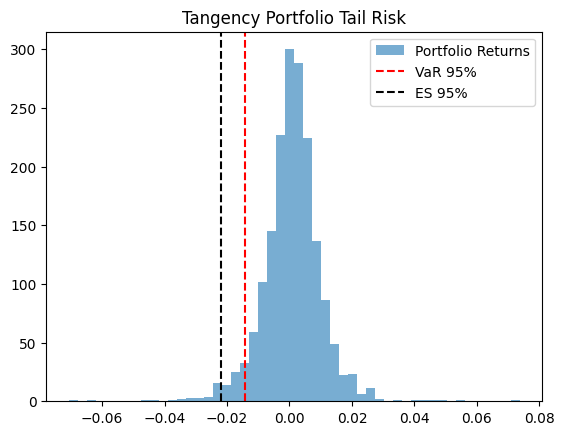

In [77]:
plt.hist(port_rets, bins=50, alpha=0.6, label="Portfolio Returns")
plt.axvline(VaR_95, color='r', linestyle='--', label="VaR 95%")
plt.axvline(ES_95, color='k', linestyle='--', label="ES 95%")
plt.legend()
plt.title("Tangency Portfolio Tail Risk")
plt.show()

In [81]:
# ----- inputs -----
rets_clean = rets.dropna()              # your asset daily log returns (DataFrame)
w = w_tan                               # tangency weights (array-like aligned to rets columns)
alpha = 0.05                            # 95% VaR/ES
n_sims = len(rets_clean)                # simulate same length; bump to e.g. 10000 for smoother tails
df_t = 2.1                              # degrees of freedom for t-copula
rng = np.random.default_rng(42)         # reproducible

# ----- fit marginal transforms (empirical -> U(0,1)) -----
qt = QuantileTransformer(output_distribution='uniform')
U_emp = qt.fit_transform(rets_clean.values)

# estimate dependence (rank/Gaussian space)
Z_emp = norm.ppf(np.clip(U_emp, 1e-12, 1 - 1e-12))
R = np.corrcoef(Z_emp, rowvar=False)  # correlation matrix for copulas

def simulate_gaussian_copula(R, n, rng):
    """Sample U~Gaussian copula with correlation R."""
    Z = rng.multivariate_normal(mean=np.zeros(R.shape[0]), cov=R, size=n)
    U = norm.cdf(Z)
    return U

def simulate_t_copula(R, df, n, rng):
    """Sample U~Student-t copula with correlation R and degrees of freedom df."""
    # sample multivariate normal with corr R
    Z = rng.multivariate_normal(mean=np.zeros(R.shape[0]), cov=R, size=n)
    # independent scaling ~ sqrt(df / ChiSq(df)) to get multivariate t
    g = rng.chisquare(df, size=n) / df
    Tz = Z / np.sqrt(g)[:, None]
    U = t.cdf(Tz, df=df)
    return U

def port_from_U(U, qt, columns, w):
    U_df = pd.DataFrame(U, columns=columns)
    X = qt.inverse_transform(U_df)
    dfX = pd.DataFrame(X, columns=columns)
    return dfX @ pd.Series(w, index=columns)

def var_es(x, alpha=0.05):
    VaR = np.percentile(x, 100*alpha)
    ES  = x[x <= VaR].mean()
    return VaR, ES

# ----- simulate & compute risk -----
U_g = simulate_gaussian_copula(R, n_sims, rng)
U_t = simulate_t_copula(R, df_t, n_sims, rng)

port_g = port_from_U(U_g, qt, rets_clean.columns, w)
port_t = port_from_U(U_t, qt, rets_clean.columns, w)

VaR_g, ES_g = var_es(port_g.values, alpha)
VaR_t, ES_t = var_es(port_t.values, alpha)

# summary table
summary = pd.DataFrame({
    "Model": ["Gaussian Copula", f"Student-t Copula (ν={df_t})"],
    "VaR 95%": [VaR_g, VaR_t],
    "ES 95%":  [ES_g,  ES_t]
})
summary


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(


,Model,VaR 95%,ES 95%
0,Gaussian Copula,-0.015,-0.021
1,Student-t Copula (ν=2.1),-0.014,-0.022


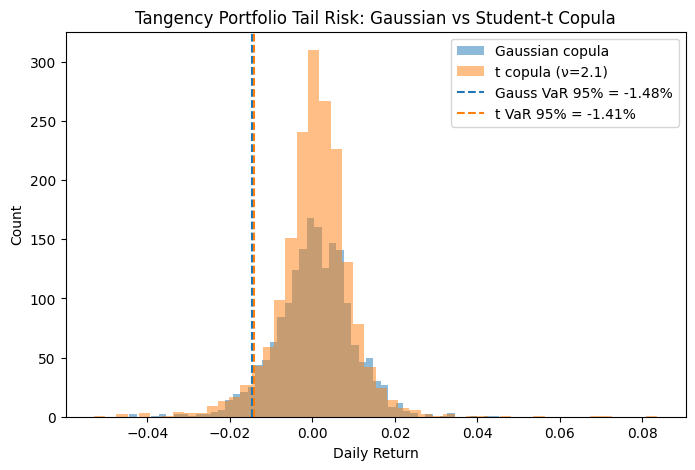

In [82]:
plt.figure(figsize=(8,5))
plt.hist(port_g, bins=50, alpha=0.5, label="Gaussian copula")
plt.hist(port_t, bins=50, alpha=0.5, label=f"t copula (ν={df_t})")
plt.axvline(VaR_g, color='C0', ls='--', label=f"Gauss VaR 95% = {VaR_g:.2%}")
plt.axvline(VaR_t, color='C1', ls='--', label=f"t VaR 95% = {VaR_t:.2%}")
plt.title("Tangency Portfolio Tail Risk: Gaussian vs Student-t Copula")
plt.xlabel("Daily Return"); plt.ylabel("Count"); plt.legend(); plt.show()

In [85]:
# ---------- helpers ----------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import norm, t as student_t

def simulate_gaussian_copula(R, n, rng):
    Z = rng.multivariate_normal(mean=np.zeros(R.shape[0]), cov=R, size=n)
    return norm.cdf(Z)

def simulate_t_copula(R, df, n, rng):
    Z = rng.multivariate_normal(mean=np.zeros(R.shape[0]), cov=R, size=n)
    g = rng.chisquare(df, size=n) / df
    Tz = Z / np.sqrt(g)[:, None]
    return student_t.cdf(Tz, df=df)

def port_from_U(U, qt, columns, w):
    U_df = pd.DataFrame(U, columns=columns)
    X = qt.inverse_transform(U_df)   # back to daily log-returns per asset
    dfX = pd.DataFrame(X, columns=columns)
    return dfX @ pd.Series(w, index=columns)

def var_es(simple_returns, alpha=0.05):
    VaR = np.percentile(simple_returns, 100*alpha)
    ES  = simple_returns[simple_returns <= VaR].mean()
    return VaR, ES

def prepare_copula_inputs(rets_df):
    """Fit rank transform and Gaussian-space correlation."""
    qt = QuantileTransformer(output_distribution='uniform')
    qt.fit(rets_df)                                # keep feature names
    U_emp = qt.transform(rets_df)
    Z_emp = norm.ppf(np.clip(U_emp, 1e-12, 1-1e-12))
    R = np.corrcoef(Z_emp, rowvar=False)
    return qt, R, rets_df.columns

# ---------- main, edit-friendly wrapper ----------
def tail_risk_sim(rets_df,
                  w,
                  horizon=5,
                  model="Gaussian",           # "Gaussian", "Student-t", or "both"
                  confidence=0.95,
                  df_t=5,
                  n_sims=10_000,
                  seed=42,
                  qt=None, R=None, cols=None, # pass precomputed to save time, else auto-fit
                  show_plot=True):
    """
    Simulate portfolio returns via a copula and compute VaR/ES at a given horizon.

    rets_df : DataFrame of daily log returns (T x d)
    w       : weights aligned with rets_df.columns
    """

    # prep
    alpha = 1 - confidence
    rng = np.random.default_rng(seed)

    if (qt is None) or (R is None) or (cols is None):
        qt, R, cols = prepare_copula_inputs(rets_df)

    # simulate a bit longer so rolling sums have enough samples
    n = n_sims + horizon - 1

    def _one(model_name):
        if model_name == "Gaussian":
            U = simulate_gaussian_copula(R, n, rng)
        else:
            U = simulate_t_copula(R, df_t, n, rng)

        port_log = port_from_U(U, qt, cols, w)     # daily log returns
        agg_log  = port_log.rolling(window=horizon).sum().dropna()
        agg_simple = np.expm1(agg_log.values)      # horizon simple return
        VaR, ES = var_es(agg_simple, alpha=alpha)
        return agg_simple, VaR, ES

    results = []
    to_plot = []

    if model.lower() == "both":
        for m in ("Gaussian", "Student-t"):
            sim, VaR, ES = _one(m)
            results.append((m, VaR, ES, len(sim)))
            to_plot.append((m, sim, VaR, ES))
    else:
        sim, VaR, ES = _one(model)
        results.append((model, VaR, ES, len(sim)))
        to_plot.append((model, sim, VaR, ES))

    # plot
    if show_plot:
        plt.figure(figsize=(8,5))
        for m, sim, VaR, ES in to_plot:
            plt.hist(sim, bins=60, alpha=0.55, edgecolor="k", label=f"{m}")
            plt.axvline(VaR, color="tab:red", ls="--", lw=1.6, label=f"{m} VaR {int(confidence*100)}% = {VaR:.2%}")
            plt.axvline(ES,  color="tab:gray", ls="--", lw=1.2, label=f"{m} ES  {int(confidence*100)}% = {ES:.2%}")
        title = f"{model} copula — {horizon}-day horizon" if model!="both" else f"Gaussian vs Student-t — {horizon}-day horizon"
        if model.lower() != "gaussian":
            title += f" (ν={df_t})" if model!="both" else ""
        plt.title(title)
        plt.xlabel(f"{horizon}-day simple return")
        plt.ylabel("Frequency")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # summary table
    summary = pd.DataFrame({
        "Model": [r[0] for r in results],
        "Horizon (days)": horizon,
        f"VaR {int(confidence*100)}%": [r[1] for r in results],
        f"ES {int(confidence*100)}%":  [r[2] for r in results],
        "Samples": [r[3] for r in results]
    })
    return summary

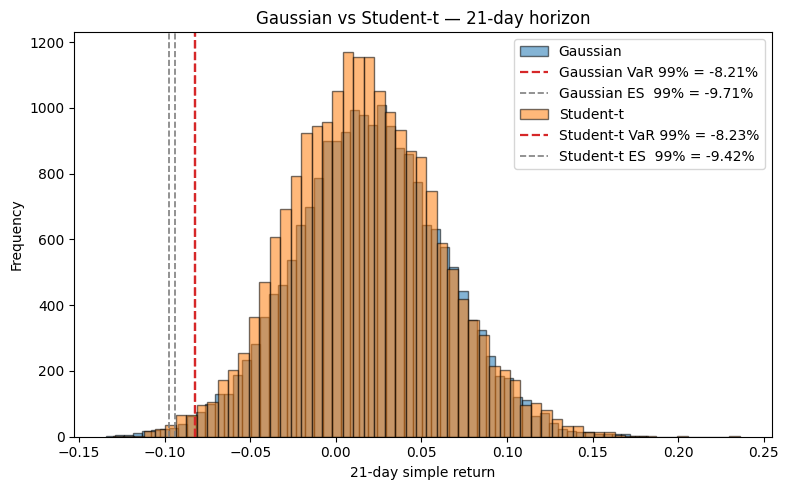

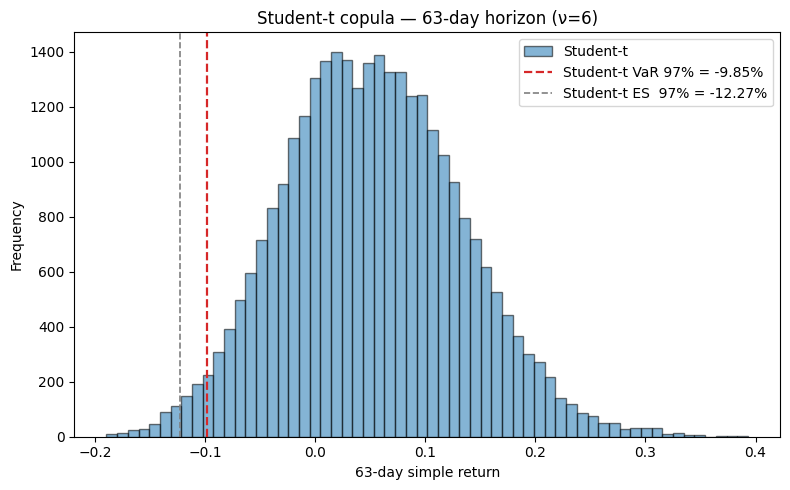

,Model,Horizon (days),VaR 97%,ES 97%,Samples
0,Student-t,63,-0.098,-0.123,30000


In [86]:
summary = tail_risk_sim(rets.dropna(), w_tan, horizon=21, model="both", confidence=0.99, df_t=4, n_sims=20000, seed=7)
summary

# reuse precomputed transforms for speed
qt, R, cols = prepare_copula_inputs(rets.dropna())
summary_3m = tail_risk_sim(rets.dropna(), w_tan, horizon=63, model="Student-t",
                           confidence=0.975, df_t=6, n_sims=30000, seed=123,
                           qt=qt, R=R, cols=cols)
summary_3m

In [90]:
# ---------- utilities ----------
def pseudo_obs(x):
    """Map 1D array to pseudo-observations U(0,1) via ranks."""
    x = np.asarray(x)
    r = np.argsort(np.argsort(x)) + 1
    return r / (len(x) + 1)

def empirical_copula_values(u, v):
    """C_n(u_i, v_i) = (1/n) * #{j : u_j<=u_i, v_j<=v_i} for each i."""
    u = np.asarray(u); v = np.asarray(v)
    # O(n^2) but fine for a few thousand points
    H = (u[:, None] >= u[None, :]) & (v[:, None] >= v[None, :])
    return H.mean(axis=1)

def simulate_gaussian_copula(rho, n, rng):
    cov = np.array([[1.0, rho], [rho, 1.0]])
    Z = rng.multivariate_normal([0.0, 0.0], cov, size=n)
    U = norm.cdf(Z)
    return U[:, 0], U[:, 1]

def simulate_t_copula(rho, df, n, rng):
    cov = np.array([[1.0, rho], [rho, 1.0]])
    Z = rng.multivariate_normal([0.0, 0.0], cov, size=n)
    g = rng.chisquare(df, size=n) / df
    Tz = Z / np.sqrt(g)[:, None]
    U = student_t.cdf(Tz, df=df)
    return U[:, 0], U[:, 1]

# ---------- main plotting function set ----------
def normal_scores_plot(x, y, ax=None, title="Normal-scores (Gaussianized)"):
    u, v = pseudo_obs(x), pseudo_obs(y)
    z1, z2 = norm.ppf(u), norm.ppf(v)
    ax = ax or plt.gca()
    ax.scatter(z1, z2, s=6, alpha=0.5)
    ax.set_title(title)
    ax.set_xlabel("Φ^{-1}(rank(X)/(n+1))")
    ax.set_ylabel("Φ^{-1}(rank(Y)/(n+1))")
    ax.axhline(0, ls=":", lw=1); ax.axvline(0, ls=":", lw=1)
    return ax

def chi_plot(x, y, ax=None, title="Chi-plot"):
    u, v = pseudo_obs(x), pseudo_obs(y)
    Cvals = empirical_copula_values(u, v)
    lam = np.sqrt(u*(1-u)*v*(1-v))
    chi = (Cvals - u*v) / np.sqrt(np.maximum(lam**2, 1e-12))
    ax = ax or plt.gca()
    ax.scatter(lam, chi, s=6, alpha=0.6)
    ax.axhline(0, color="k", lw=1, ls="--")
    ax.set_xlabel("λ = √{u(1−u)v(1−v)}")
    ax.set_ylabel("χ = [C_n(u,v) − uv] / √{u(1−u)v(1−v)}")
    ax.set_title(title + " (independence ⇒ χ≈0)")
    return ax

def kendall_k_plot(x, y, model=None, df=5, m=20000, ax=None,
                   rng=np.random.default_rng(0),
                   title="Kendall K-plot"):
    """Empirical K-plot with independence line and optional model overlay (Gaussian or t)."""
    u, v = pseudo_obs(x), pseudo_obs(y)
    c_emp = np.sort(empirical_copula_values(u, v))
    n = len(u)
    y_emp = np.linspace(1/n, 1, n)

    ax = ax or plt.gca()
    ax.plot(c_emp, y_emp, label="Empirical")
    ax.plot([0,1], [0,1], ls="--", label="Independence")

    if model is not None:
        # estimate dependence via Kendall's τ, map to ρ (works for Gaussian & t)
        tau = stats.kendalltau(x, y).correlation
        rho = np.sin(0.5*np.pi*tau)
        if model.lower().startswith("gauss"):
            ug, vg = simulate_gaussian_copula(rho, m, rng)
            c_mod = np.sort(empirical_copula_values(ug, vg))
            ax.plot(c_mod, np.linspace(1/m, 1, m), label=f"Gaussian ρ≈{rho:.2f}")
        else:
            ut, vt = simulate_t_copula(rho, df, m, rng)
            c_mod = np.sort(empirical_copula_values(ut, vt))
            ax.plot(c_mod, np.linspace(1/m, 1, m), label=f"t-copula ν={df}, ρ≈{rho:.2f}")

    ax.set_xlabel("t")
    ax.set_ylabel("K_n(t)")
    ax.set_title(title)
    ax.legend()
    return ax

def copula_pp_plot(x, y, model="gaussian", df=5, m=20000, ax=None,
                   rng=np.random.default_rng(1),
                   title="Copula P–P (Q–Q style)"):
    """Plot empirical copula values vs model copula values (both sorted). Perfect fit → 45° line."""
    u, v = pseudo_obs(x), pseudo_obs(y)
    c_emp = np.sort(empirical_copula_values(u, v))

    tau = stats.kendalltau(x, y).correlation
    rho = np.sin(0.5*np.pi*tau)
    if model.lower().startswith("gauss"):
        ug, vg = simulate_gaussian_copula(rho, m, rng)
        c_mod = np.sort(empirical_copula_values(ug, vg))
        label = f"Gaussian ρ≈{rho:.2f}"
    else:
        ut, vt = simulate_t_copula(rho, df, m, rng)
        c_mod = np.sort(empirical_copula_values(ut, vt))
        label = f"t-copula ν={df}, ρ≈{rho:.2f}"

    # align sizes
    k = min(len(c_emp), len(c_mod))
    xvals, yvals = c_emp[:k], c_mod[:k]

    ax = ax or plt.gca()
    ax.plot(xvals, yvals, ".", ms=4, alpha=0.7, label=label)
    ax.plot([0,1], [0,1], "k--", lw=1)
    ax.set_xlabel("Empirical copula values (sorted)")
    ax.set_ylabel("Model copula values (sorted)")
    ax.set_title(title)
    ax.legend()
    return ax


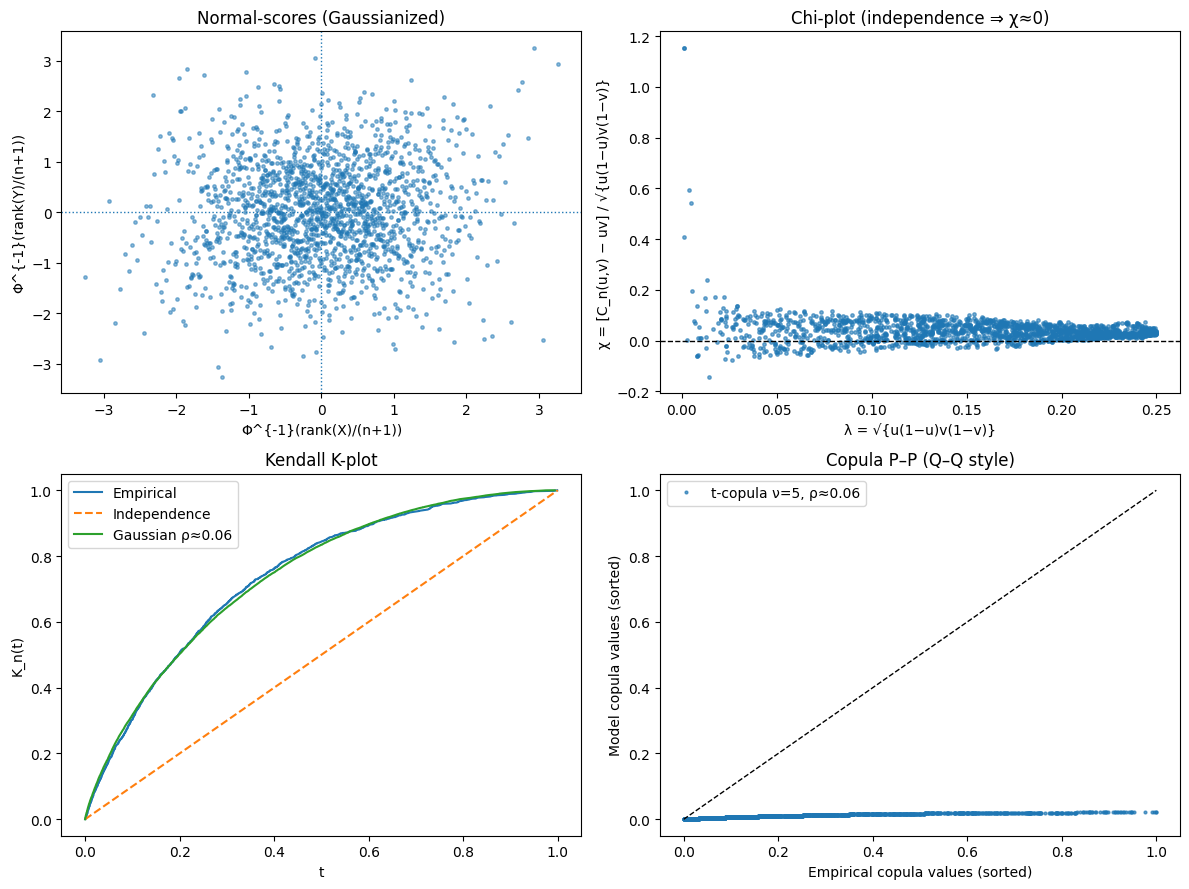

In [91]:
x = rets["QQQ"].dropna()
y = rets["IAU"].dropna()
n = min(len(x), len(y))
x, y = x.iloc[-n:], y.iloc[-n:]   # align lengths

plt.figure(figsize=(12,9))
plt.subplot(2,2,1); normal_scores_plot(x, y)
plt.subplot(2,2,2); chi_plot(x, y)
plt.subplot(2,2,3); kendall_k_plot(x, y, model="gaussian")  # add model overlay
plt.subplot(2,2,4); copula_pp_plot(x, y, model="t", df=5)   # “Q-Q style”
plt.tight_layout(); plt.show()

In [95]:
def simulate_copula(model="gaussian", rho=0.7, df=5, n=5000, rng=np.random.default_rng(0)):
    """Simulate (U,V) from specified copula."""
    cov = np.array([[1, rho], [rho, 1]])
    Z = rng.multivariate_normal([0, 0], cov, size=n)
    if model == "gaussian":
        U = norm.cdf(Z[:,0])
        V = norm.cdf(Z[:,1])
    elif model == "t":
        g = rng.chisquare(df, size=n) / df
        Tz = Z / np.sqrt(g)[:, None]
        U = t.cdf(Tz[:,0], df)
        V = t.cdf(Tz[:,1], df)
    else:
        raise ValueError("model must be 'gaussian' or 't'")
    return np.vstack([U, V])

def plot_copula_density(UV, model_name="Gaussian", levels=20):
    """2D KDE over unit square [0,1]^2 with contour fill"""
    kde = gaussian_kde(UV)

    # Grid for [0,1]^2
    xgrid = ygrid = np.linspace(0, 1, 200)
    X, Y = np.meshgrid(xgrid, ygrid)
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = kde(positions).reshape(X.shape)

    # Plot
    plt.figure(figsize=(6,5))
    cp = plt.contourf(X, Y, Z, levels=levels, cmap="viridis")
    plt.colorbar(cp, label="Density")
    plt.title(f"{model_name} Copula Density (U,V)")
    plt.xlabel("U"); plt.ylabel("V")
    plt.xlim(0,1); plt.ylim(0,1)
    plt.grid(alpha=0.2)
    plt.show()


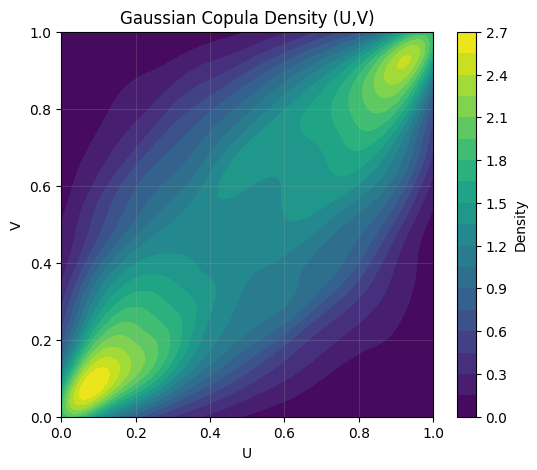

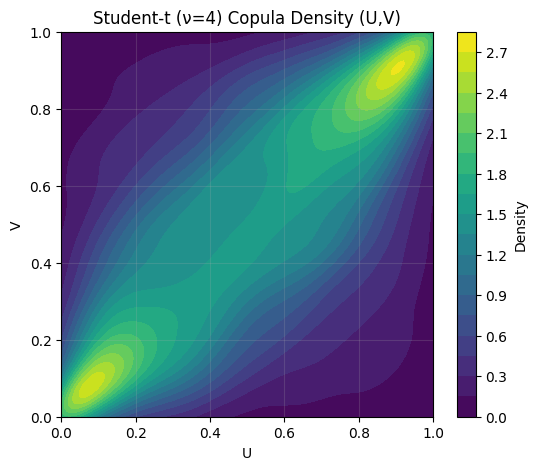

In [96]:
# Gaussian Copula (ρ=0.7)
UVg = simulate_copula("gaussian", rho=0.7)
plot_copula_density(UVg, model_name="Gaussian")

# Student-t Copula (ρ=0.7, ν=4)
UVt = simulate_copula("t", rho=0.7, df=4)
plot_copula_density(UVt, model_name="Student-t (ν=4)")


In [97]:
port_rets = rets @ w_tan   # Tangency portfolio daily log returns
port_rets = port_rets.dropna()# Ensure your return series is a pandas Series with a DatetimeIndex
port_rets.index = pd.to_datetime(port_rets.index)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1793
Model:                     AutoReg(1)   Log Likelihood                5805.117
Method:               Conditional MLE   S.D. of innovations              0.009
Date:                Sun, 17 Aug 2025   AIC                         -11604.235
Time:                        01:28:50   BIC                         -11587.762
Sample:                             1   HQIC                        -11598.153
                                 1793                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.000      3.992      0.000       0.000       0.001
y.L1          -0.0535      0.024     -2.267      0.023      -0.100      -0.007
                                    Roots           

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


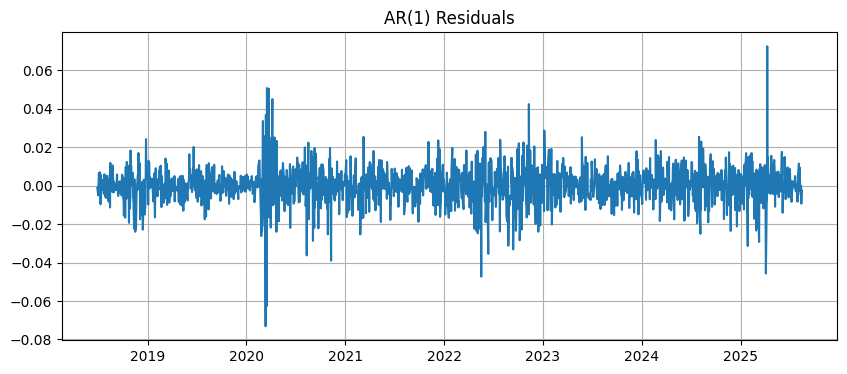

In [98]:
model_ar = AutoReg(port_rets, lags=1)
res_ar = model_ar.fit()
print(res_ar.summary())

# Plot residuals
resid = res_ar.resid
plt.figure(figsize=(10,4))
plt.plot(resid)
plt.title("AR(1) Residuals"); plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1793
Model:                 ARIMA(1, 0, 1)   Log Likelihood                5794.426
Date:                Sun, 17 Aug 2025   AIC                         -11580.852
Time:                        01:28:59   BIC                         -11558.886
Sample:                             0   HQIC                        -11572.742
                               - 1793                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      3.848      0.000       0.000       0.001
ar.L1         -0.9432      0.033    -28.902      0.000      -1.007      -0.879
ma.L1          0.8952      0.035     25.338      0.0

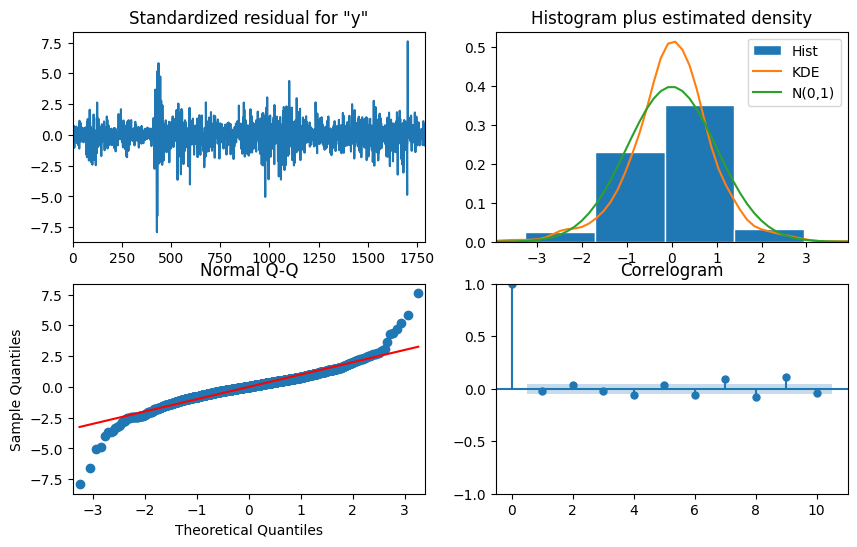

In [99]:
model_arima = ARIMA(port_rets, order=(1,0,1))  # ARMA(1,1)
res_arima = model_arima.fit()
print(res_arima.summary())
res_arima.plot_diagnostics(figsize=(10,6))
plt.show()

                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2369.29
Distribution:                  Normal   AIC:                           4744.59
Method:            Maximum Likelihood   BIC:                           4761.06
                                        No. Observations:                 1793
Date:                Sun, Aug 17 2025   Df Residuals:                     1792
Time:                        01:29:11   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1097  2.402e-02      4.568  4.923e-06 [6.266e-0

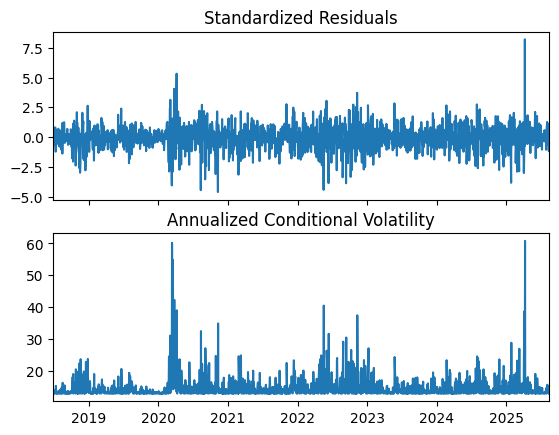

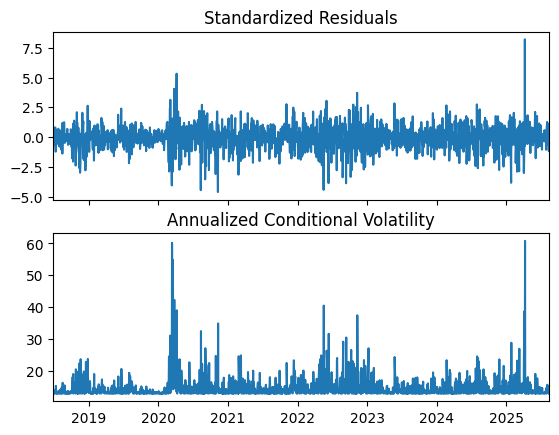

In [100]:
# Rescale returns by 100
rets_scaled = 100 * port_rets

model_arch = arch_model(rets_scaled, vol="ARCH", p=1)
res_arch = model_arch.fit(disp="off")
print(res_arch.summary())
res_arch.plot(annualize="D")

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2227.48
Distribution:                  Normal   AIC:                           4462.97
Method:            Maximum Likelihood   BIC:                           4484.93
                                        No. Observations:                 1793
Date:                Sun, Aug 17 2025   Df Residuals:                     1792
Time:                        01:29:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0927  1.798e-02      5.158  2.497e-07 [5.749e-0

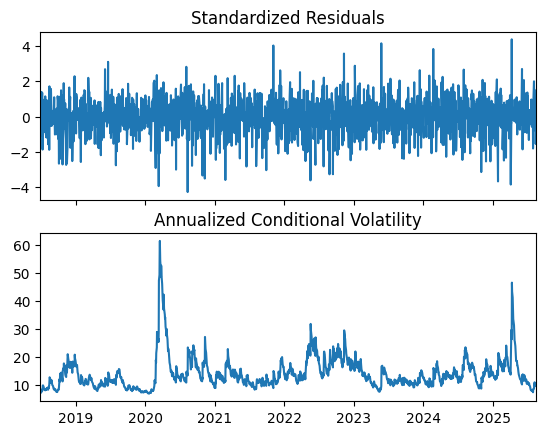

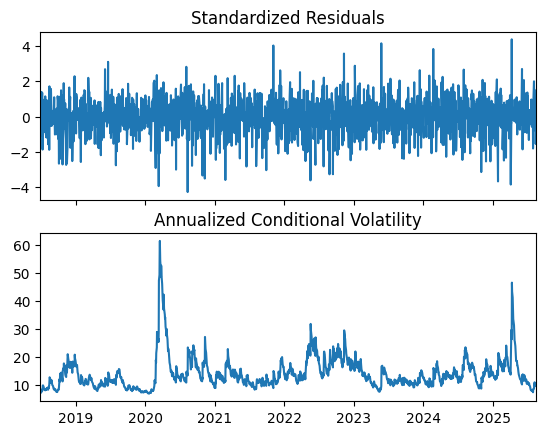

In [101]:
model_garch = arch_model(rets_scaled, vol="GARCH", p=1, q=1)
res_garch = model_garch.fit(disp="off")
print(res_garch.summary())
res_garch.plot(annualize="D")